- CIS 9440 - Data Warehousing for Analytics

- Homework #2

- Student – **KWANG HEUM YEON**

# Homework #2 - ETL

This ETL process is for homework #2 of CIS 9440, Zicklin School of Business in Baruch College. The dimensional model was suggested, and we have 9 stages to get the result and those are briefly as follows: 

(1)	Download data and import into the code cell 

(2)	Data profiling, cleansing, and finally exploring

(3)	Create a fact table and each dimension table

(4) Deliver fact tables and each dimension table to the data warehouse (Big Query) and export each file as CSV format.

(5)	Appendix

Each code cell will contain a comment. In the appendix, we will attach the test images screen-captured from the data warehouse (Big Query) and BI application (Tableau) to check if the delivered tables are properly recognized.

## Step 1: Download data

This dataset was downloaded from gapminder.org

1. download the CSV from the link and save it to the local storage. 
2. read the file in a DataFrame format
3. transform data by melting the required variable 

In [1]:
# import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from google.cloud import bigquery
from google.oauth2 import service_account

In [2]:
income_data = pd.read_csv('income_per_person_inflation_adjusted.csv')
income_data.tail(2)

,country,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040
191,Zambia,663,665,667,668,670,671,673,675,676,...,3500,3560,3630,3700,3780,3860,3930,4010,4100,4180
192,Zimbabwe,869,870,871,872,873,874,875,876,877,...,2630,2680,2730,2780,2840,2900,2960,3020,3080,3140


In [3]:
# melt the variable and declear the melted variable name and value name
income_data_formatted = income_data.melt(id_vars = ['country'], var_name = 'year', value_name = 'income_per_person').reset_index(drop = True)
income_data_formatted.sample(2)

,country,year,income_per_person
13041,Moldova,1867,804
11034,Chad,1857,501


In [4]:
# export the original dataset 
income_data_formatted.to_csv('income_data_formatted.csv')

In [5]:
df = income_data_formatted.copy()

In [6]:
# check file size and data type for variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46513 entries, 0 to 46512
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   country            46513 non-null  object
 1   year               46513 non-null  object
 2   income_per_person  46513 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


## Step 2: Data Profiling

1. Distinct values per column
2. Null values per column
3. Summary statistics per numeric column

In [7]:
# loop through each column to add rows to the data_profiling each column

data_profiling = pd.DataFrame()

for column in df.columns:
    
    info_dict = {}
    
    try:
        info_dict["column_name"] = column
        info_dict["column_type"] = df[column].dtypes
        info_dict["unique_values"] = len(df[column].unique())
        info_dict["duplicate_values"] = (df[column].shape[0] - df[column].isna().sum()) - len(df[column].unique())
        info_dict["null_values"] = df[column].isna().sum()
        info_dict["non_null_values"] = df[column].shape[0] - df[column].isna().sum()
        info_dict["percent_null"] = round((df[column].isna().sum()) / (df[column].shape[0]), 3)
        
    except:
        print(f"unable to read column: {column}")
    
    data_profiling = data_profiling.append(info_dict, ignore_index=True)
    
data_profiling.sort_values(by = ['unique_values', "non_null_values"],
                              ascending = [False, False],
                              inplace=True)

In [8]:
data_profiling

,column_name,column_type,unique_values,duplicate_values,null_values,non_null_values,percent_null
2,income_per_person,int64,2417.0,44096.0,0.0,46513.0,0.0
1,year,object,241.0,46272.0,0.0,46513.0,0.0
0,country,object,193.0,46320.0,0.0,46513.0,0.0


In [9]:
# check Five-number summary for numeric variables
df.describe()

,income_per_person
count,46513.000000
mean,6428.630340
std,13353.029625
min,245.000000
25%,899.000000
50%,1750.000000
75%,4830.000000
max,179000.000000


## Step 3: Data Cleansing

1. drop unneeded columns
2. drop duplicate rows
3. check for outliers

In [10]:
# check duplicated values 
print(f"Sum of duplicated values: {df.duplicated().sum()}")

Sum of duplicated values: 0


In [11]:
# check Null values 
print(f"Sum of null values: \n{df.isna().sum()}")

Sum of null values: 
country              0
year                 0
income_per_person    0
dtype: int64


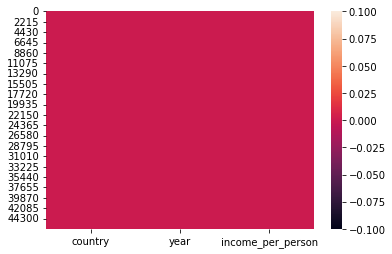

In [12]:
# double-check Null values 
sb.heatmap(df.isnull()); # if all red, no null value

## Step 4: Data Exploring
1. check the distribution of data 
2. plot sample charts

In [13]:
top_2021 = df[df['year'] == '2021'].sort_values('income_per_person', ascending = False).head()
top_2021 # top 5 countries in 2021

,country,year,income_per_person
42792,Qatar,2021,119000
42751,Luxembourg,2021,95800
42804,Singapore,2021,91400
42677,Brunei,2021,76900
42733,Ireland,2021,75700


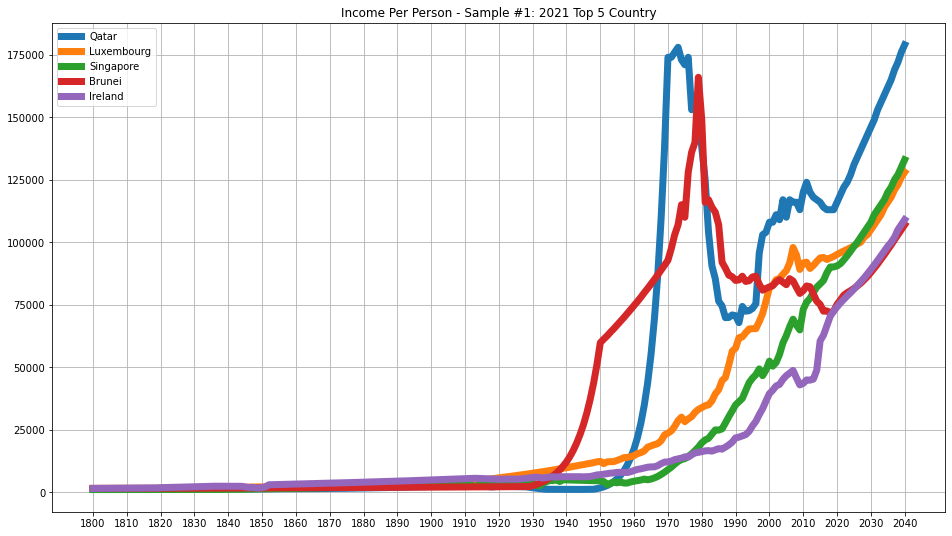

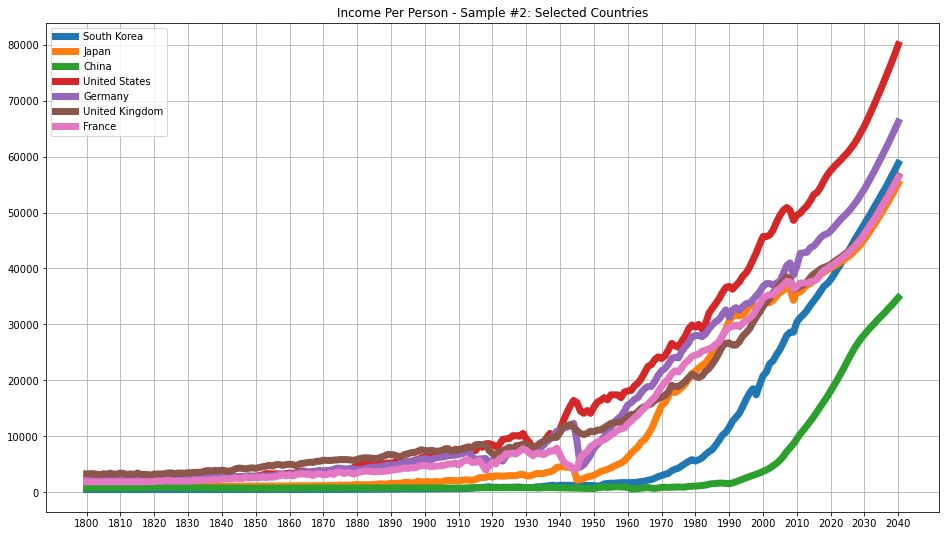

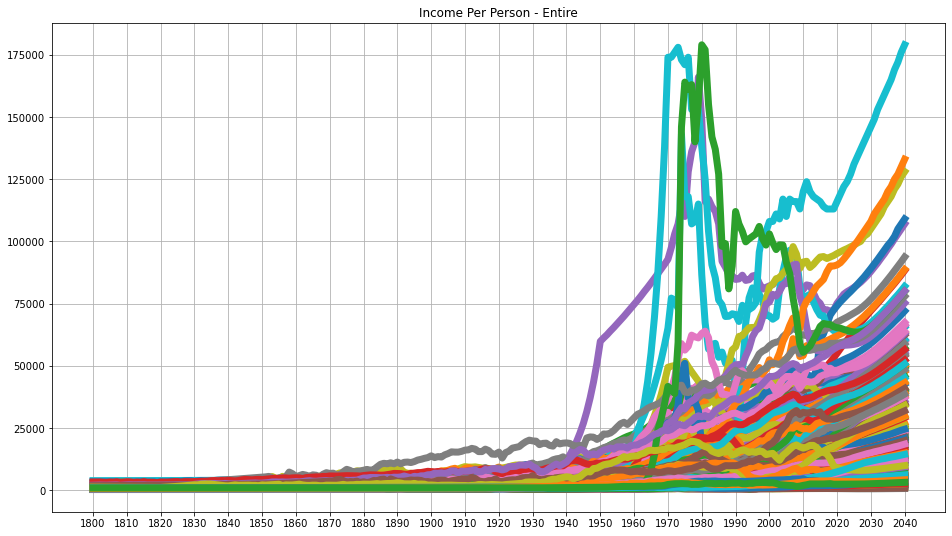

       country  year  income_per_person
0  Afghanistan  1800                603 


        country  year  income_per_person
46512  Zimbabwe  2040               3140 


       income_per_person
count       46513.000000
mean         6428.630340
std         13353.029625
min           245.000000
25%           899.000000
50%          1750.000000
75%          4830.000000
max        179000.000000


In [14]:
# plot line chart for the selected countries

def name(i):
    df_name = df[df['country'] == i]
    return df_name
 
# selected countries 1
cart = top_2021.country.unique()
plt.figure(figsize = (16,9))
plt.title('Income Per Person - Sample #1: 2021 Top 5 Country')
plt.grid(axis = 'x')
plt.grid(axis = 'y')
for i in cart:
    plt.errorbar(data = name(i), x = 'year', y = 'income_per_person', linewidth = 7, label = name(i).country.unique()[0])
    plt.xticks(['{}'.format(i) for i in np.arange(1800, 2050, 10)])
    plt.legend()
 
# selected countries 2
cart = ['South Korea', 'Japan', 'China', 'United States', 'Germany', 'United Kingdom', 'France']
plt.figure(figsize = (16,9))
plt.title('Income Per Person - Sample #2: Selected Countries')
plt.grid(axis = 'x')
plt.grid(axis = 'y')
for i in cart:
    plt.errorbar(data = name(i), x = 'year', y = 'income_per_person', linewidth = 7, label = name(i).country.unique()[0])
    plt.xticks(['{}'.format(i) for i in np.arange(1800, 2050, 10)])
    plt.legend()
    
# entire countries
cart = df.country.unique()
plt.figure(figsize = (16,9))
plt.title('Income Per Person - Entire')
plt.grid(axis = 'x')
plt.grid(axis = 'y')
for i in cart:
    plt.errorbar(data = name(i), x = 'year', y = 'income_per_person', linewidth = 7, label = name(i).country.unique()[0])
    plt.xticks(['{}'.format(i) for i in np.arange(1800, 2050, 10)])
    
plt.show()

print(df.head(1),'\n\n')
print(df.tail(1),'\n\n')
print(df.describe())

- x-axis and y-axis distributed within the statistic range

- each plot has neither overlapped nor disconnected pattern owing to duplicated or null values

## Step 5: Create Date Dimension

In [15]:
# first, copy the entire table

date_dim = df.copy()

In [16]:
# second, subset for only the wanted columns in the dimension

date_dim = date_dim[['year']]

In [17]:
# third, drop duplicate rows in dimension

date_dim = date_dim.drop_duplicates(subset = ["year"], keep = "first").reset_index(drop = True)

In [18]:
# fourth, create decade column

date_dim = date_dim.astype(int) # change the type to int
date_dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    241 non-null    int32
dtypes: int32(1)
memory usage: 1.1 KB


In [19]:
date_dim['decade'] = date_dim['year'] - (date_dim['year'] %10)
date_dim = date_dim.astype(str) # change the type back to marge

In [20]:
# fifth, add date_id as a surrogate key

date_dim.insert(0, "date_id", range(1000, 1000+len(date_dim)))
date_dim.head(2)

,date_id,year,decade
0,1000,1800,1800
1,1001,1801,1800


In [21]:
# sixth, add the date_id to the Fact table

df = df.merge(date_dim,
              left_on = 'year',
              right_on = 'year',
              how = 'left')

df.head(2)

,country,year,income_per_person,date_id,decade
0,Afghanistan,1800,603,1000,1800
1,Albania,1800,667,1000,1800


## Step 6: Create Country Dimension

In [22]:
# first, copy the entire table

country_dim = df.copy()

In [23]:
# second, subset for only the wanted columns in the dimension

country_dim = country_dim[['country']]

In [24]:
# third, drop duplicate rows in dimension

country_dim = country_dim.drop_duplicates(subset = ["country"], keep = "first").reset_index(drop = True)

In [25]:
# fourth, add country_id as a surrogate key

country_dim.insert(0, "country_id", range(100, 100+len(country_dim)))
country_dim.head(2)

,country_id,country
0,100,Afghanistan
1,101,Albania


In [26]:
# fifth, add the date_id to the Fact table

df = df.merge(country_dim,
              left_on = 'country',
              right_on = 'country',
              how = 'left')

df.head(2)

,country,year,income_per_person,date_id,decade,country_id
0,Afghanistan,1800,603,1000,1800,100
1,Albania,1800,667,1000,1800,101


## Step 7: Creating Fact

In [27]:
# GDP Fact Table

gdp_fact = df[["date_id",
               "country_id",
               "income_per_person"]]
gdp_fact.head(2)

,date_id,country_id,income_per_person
0,1000,100,603
1,1000,101,667


## Step 9: Deliver Facts and Dimensions to Data Warehouse (BigQuery)

In [28]:
# first, create a BigQuery client to connect to BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account

key_path = r'C:\Users\aicpa\Google Drive\_CPADataScientistValueInvestor\_DataWarehouse\cis9440-340819-fdb3569fc29a.json' # must edit to your credentials json file location
credentials = service_account.Credentials.from_service_account_file(key_path,
                                                                    scopes=["https://www.googleapis.com/auth/cloud-platform"],)
client = bigquery.Client(credentials = credentials,
                         project = credentials.project_id)

In [29]:
print(client)

In [30]:
# build a function to load tables to BigQuery

def load_table_to_bigquery(df, table_name):
    
    dataset_id = 'cis9440-340819.CIS9440_HW_2'
    
    dataset_ref = client.dataset(dataset_id)
    job_config = bigquery.LoadJobConfig()
    job_config.autodetect = True
    job_config.write_disposition = "WRITE_TRUNCATE"
    
    upload_table_name = f"cis9440-340819.CIS9440_HW_2.{table_name}"
    
    load_job = client.load_table_from_dataframe(df,
                                                upload_table_name,
                                                job_config = job_config)
    
    print(f"starting job {load_job}")

In [31]:
load_table_to_bigquery(df = date_dim, table_name = "date_dim")

starting job LoadJob<project=cis9440-340819, location=US, id=21812bda-e0b7-4444-8162-4f9ce011d87d>


In [32]:
load_table_to_bigquery(df = country_dim, table_name = "country_dim")

starting job LoadJob<project=cis9440-340819, location=US, id=eb8549a2-6e33-4809-b8b7-38bba58bc44a>


In [33]:
load_table_to_bigquery(df = gdp_fact, table_name = "gdp_fact")

starting job LoadJob<project=cis9440-340819, location=US, id=f40f442b-e2c1-4de7-8dd0-63171c098359>


## Step 8: Export dataset as CSV

In [34]:
gdp_fact.to_csv('gdp_fact.csv', index = False)
date_dim.to_csv('date_dim.csv', index = False)
country_dim.to_csv('country_dim.csv', index = False)

## Appendix

(Next page)